Device: cuda
Train: 80, Val: 20, Test: 50
Visualizing sample | Frames = 30 | Label = HCM


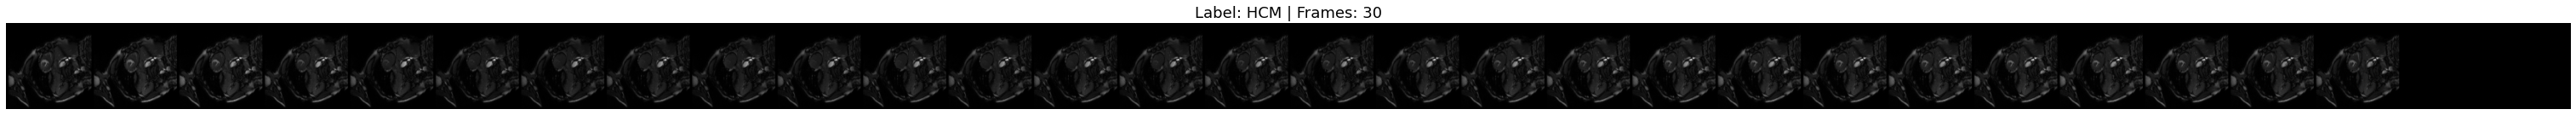

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from Data_loader import ACDC_Dataset, pad_collate  
import torchvision.utils as vutils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------------------------
# 
# ---------------------------------------------------------
train_root = "/workspace/Shantanu/shantanu_code/Personal_projects/dataset/training"
test_root  = "/workspace/Shantanu/shantanu_code/Personal_projects/dataset/testing"

# ---------------------------------------------------------
# Data Loader
# ---------------------------------------------------------
full_dataset = ACDC_Dataset(train_root, augment=True)

train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Disable augmentation for validation
val_dataset.dataset.augment = False

# Test dataset (no augmentation)
test_dataset = ACDC_Dataset(test_root, augment=False)

# ---------------------------------------------------------
# ✅ Standard Dataloaders (No Balanced Sampler)
# ---------------------------------------------------------
train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=pad_collate
)

val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate
)

test_loader = DataLoader(
    test_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ---------------------------------------------------------
# 
# ---------------------------------------------------------
seqs, labels = next(iter(train_loader))
seq = seqs[0]        # (T, 1, H, W)
T = seq.shape[0]

print(f"Visualizing sample | Frames = {T} | Label = {labels[0]}")

# Display frames in one row
grid = vutils.make_grid(seq, nrow=T, normalize=True, scale_each=True)

plt.figure(figsize=(T * 1.8, 4))
plt.imshow(grid[0], cmap="gray")
plt.title(f"Label: {labels[0]} | Frames: {T}", fontsize=18)
plt.axis("off")
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
from tqdm import tqdm
import pickle, os, datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from models import MobileNetLSTMClassifier, MobileNetConvLSTMClassifier  


CLASS_MAP = {"MINF":0, "DCM":1, "HCM":2, "RV":3, "NOR":4}
INV_MAP = {v:k for k,v in CLASS_MAP.items()}

AUGMENTATIONS_USED = "FrameDrop, SpeedJitter, TemporalCrop, TemporalReverse, 3D Crop, SmallRotation, GaussianNoise"

def encode_labels(labels):
    return torch.tensor([CLASS_MAP[l] for l in labels]).long()


# =====================================================
# ✅ TRAINING + TESTING FUNCTION
# =====================================================
def train_model(model_name, epochs=50, batch_size=4, lr=1e-4, weight_decay=1e-4):

    if model_name.lower() == "lstm":
        model = MobileNetLSTMClassifier(num_classes=5).to(device)
    elif model_name.lower() == "convlstm":
        model = MobileNetConvLSTMClassifier(num_classes=5).to(device)
    elif model_name.lower() == "transformer":
        model = MobileNetTransformerClassifier(
        num_classes=5,
        d_model=256,
        nhead=8,
        num_layers=4,
        dropout=0.1
       ).to(device)

    else:
        raise ValueError(" model_name must be 'lstm' or 'convlstm'")

    print(f"\n Loaded Model: {model_name.upper()} — showing summary...")

    # print model summary
    # (Batch, Time, Channel, Height, Width) -> (1, 20, 1, 224, 224)
    #summary(model, input_size=(1, 20, 1, 224, 224))
    #print("\n Model summary printed.\n")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

 
    run_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"./run_{model_name}_{run_time}"
    os.makedirs(save_dir, exist_ok=True)

    log_file = os.path.join(save_dir, f"{model_name}_training_log.txt")

    with open(log_file, "w") as f:
        f.write("==== Training Config ====\n")
        f.write(f"Model: {model_name}\nEpochs: {epochs}\nBatch Size: {batch_size}\n")
        f.write(f"LR: {lr}, Weight Decay: {weight_decay}\n")
        f.write(f"Augmentations: {AUGMENTATIONS_USED}\n=========================\n\n")

    
    best_val_acc = 0
    metrics = {k: [] for k in ["train_loss","train_acc","val_loss","val_acc","precision","recall","f1"]}

    # =====================================================
    # ✅ Training Loop
    # =====================================================
    for epoch in range(1, epochs+1):

        # ---- Training ----
        model.train()
        tr_preds, tr_labels = [], []
        total_train_loss = 0

        for seqs, labels in tqdm(train_loader, desc=f"Epoch {epoch} (Train)"):
            seqs = seqs.to(device)
            y = encode_labels(labels).to(device)

            optimizer.zero_grad()
            preds = model(seqs)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            tr_preds.extend(preds.argmax(1).cpu().numpy())
            tr_labels.extend(y.cpu().numpy())

        train_acc = accuracy_score(tr_labels, tr_preds)
        train_loss = total_train_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad():
            for seqs, labels in tqdm(val_loader, desc=f"Epoch {epoch} (Val)"):
                seqs = seqs.to(device)
                y = encode_labels(labels).to(device)
                preds = model(seqs)
                loss = criterion(preds, y)

                total_val_loss += loss.item()
                val_preds.extend(preds.argmax(1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
        recall = recall_score(val_labels, val_preds, average="weighted", zero_division=0)
        f1 = f1_score(val_labels, val_preds, average="weighted", zero_division=0)
        val_loss = total_val_loss / len(val_loader)

        scheduler.step()

        #  Record metrics
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1"].append(f1)

        msg = (f"Epoch {epoch}/{epochs} | Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | "
               f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f} | "
               f"P {precision:.4f}, R {recall:.4f}, F1 {f1:.4f}")
        print(msg)
        with open(log_file, "a") as f: f.write(msg+"\n")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            with open(os.path.join(save_dir,"best_model_info.txt"),"w") as f:
                f.write(f"Best Val Accuracy: {best_val_acc:.4f} at Epoch {epoch}")

    #  Save training metrics
    with open(os.path.join(save_dir,"metrics.pkl"), "wb") as f:
        pickle.dump(metrics, f)

    print(f"\n✅ Training complete. Best Val Acc = {best_val_acc:.4f}")
    print(f"📂 Saved: {save_dir}")


    # =====================================================
    #  TEST BEST MODEL
    # =====================================================
    print("\n🔍 Loading best model for TESTING...")
    model.load_state_dict(torch.load(os.path.join(save_dir, "best_model.pth")))
    model.eval()

    results_dir = f"results/{model_name}"
    os.makedirs(results_dir, exist_ok=True)

    test_preds, test_labels = [], []

    with torch.no_grad():
        for seqs, labels in tqdm(test_loader, desc="Testing"):
            seqs = seqs.to(device)
            y = encode_labels(labels).to(device)
            preds = model(seqs)

            test_preds.extend(preds.argmax(1).cpu().numpy())
            test_labels.extend(y.cpu().numpy())

    #  Confusion Matrix & Report
    cm = confusion_matrix(test_labels, test_preds)
    report = classification_report(test_labels, test_preds, target_names=list(CLASS_MAP.keys()))

    # Save classification report
    with open(f"{results_dir}/classification_report.txt","w") as f:
        f.write(report)

    #  Save confusion matrix plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(CLASS_MAP.keys()),
                yticklabels=list(CLASS_MAP.keys()))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.savefig(f"{results_dir}/confusion_matrix.png")
    plt.close()

    #  Save CSV of predictions
    df = pd.DataFrame({
        "true": [INV_MAP[i] for i in test_labels],
        "pred": [INV_MAP[i] for i in test_preds]
    })
    df.to_csv(f"{results_dir}/predictions.csv", index=False)

    print(f" Testing complete. Results saved in `{results_dir}`")


In [3]:
train_model("lstm", epochs=150)


 Loaded Model: LSTM — showing summary...


Epoch 1 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 1/150 | Train Loss 1.7002, Train Acc 0.1125 | Val Loss 1.7323, Val Acc 0.1000 | P 0.0333, R 0.1000, F1 0.0500


Epoch 2 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 2/150 | Train Loss 1.5470, Train Acc 0.3500 | Val Loss 1.6850, Val Acc 0.1000 | P 0.0571, R 0.1000, F1 0.0727


Epoch 3 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 3/150 | Train Loss 1.4054, Train Acc 0.5000 | Val Loss 1.6304, Val Acc 0.2000 | P 0.0946, R 0.2000, F1 0.1273


Epoch 4 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 4/150 | Train Loss 1.2657, Train Acc 0.5375 | Val Loss 1.5347, Val Acc 0.2500 | P 0.1443, R 0.2500, F1 0.1789


Epoch 5 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 5/150 | Train Loss 1.1239, Train Acc 0.6375 | Val Loss 1.4512, Val Acc 0.3500 | P 0.3750, R 0.3500, F1 0.3200


Epoch 6 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 6/150 | Train Loss 0.9361, Train Acc 0.7625 | Val Loss 1.5313, Val Acc 0.3500 | P 0.3176, R 0.3500, F1 0.3134


Epoch 7 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 7/150 | Train Loss 0.7627, Train Acc 0.7875 | Val Loss 1.2664, Val Acc 0.4000 | P 0.3563, R 0.4000, F1 0.3518


Epoch 8 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 8/150 | Train Loss 0.6287, Train Acc 0.8625 | Val Loss 1.4724, Val Acc 0.4500 | P 0.8958, R 0.4500, F1 0.5484


Epoch 9 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 9/150 | Train Loss 0.4243, Train Acc 0.9000 | Val Loss 1.5077, Val Acc 0.3500 | P 0.7250, R 0.3500, F1 0.3875


Epoch 10 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 10/150 | Train Loss 0.5448, Train Acc 0.8375 | Val Loss 1.4137, Val Acc 0.5000 | P 0.7025, R 0.5000, F1 0.5201


Epoch 11 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 11/150 | Train Loss 0.3204, Train Acc 0.9250 | Val Loss 1.4985, Val Acc 0.4500 | P 0.8400, R 0.4500, F1 0.5181


Epoch 12 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 12/150 | Train Loss 0.2640, Train Acc 0.9500 | Val Loss 1.2326, Val Acc 0.6000 | P 0.7343, R 0.6000, F1 0.6071


Epoch 13 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 13/150 | Train Loss 0.2968, Train Acc 0.8875 | Val Loss 1.5245, Val Acc 0.5500 | P 0.7357, R 0.5500, F1 0.5446


Epoch 14 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 14/150 | Train Loss 0.1509, Train Acc 0.9750 | Val Loss 1.5493, Val Acc 0.4000 | P 0.8250, R 0.4000, F1 0.4375


Epoch 15 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 15/150 | Train Loss 0.2020, Train Acc 0.9625 | Val Loss 1.2438, Val Acc 0.7000 | P 0.8450, R 0.7000, F1 0.7250


Epoch 16 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 16/150 | Train Loss 0.2593, Train Acc 0.9250 | Val Loss 1.3660, Val Acc 0.5500 | P 0.7193, R 0.5500, F1 0.5689


Epoch 17 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 17/150 | Train Loss 0.2361, Train Acc 0.9250 | Val Loss 2.0012, Val Acc 0.4000 | P 0.6362, R 0.4000, F1 0.3782


Epoch 18 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 18/150 | Train Loss 0.1393, Train Acc 0.9750 | Val Loss 1.7589, Val Acc 0.5000 | P 0.7193, R 0.5000, F1 0.5144


Epoch 19 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 19/150 | Train Loss 0.1071, Train Acc 0.9875 | Val Loss 1.7224, Val Acc 0.4000 | P 0.7810, R 0.4000, F1 0.4075


Epoch 20 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch 20/150 | Train Loss 0.0700, Train Acc 1.0000 | Val Loss 1.6383, Val Acc 0.4000 | P 0.8733, R 0.4000, F1 0.4643


Epoch 21 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch 21/150 | Train Loss 0.1061, Train Acc 0.9625 | Val Loss 1.6392, Val Acc 0.5000 | P 0.9400, R 0.5000, F1 0.6058


Epoch 22 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch 22/150 | Train Loss 0.1905, Train Acc 0.9250 | Val Loss 1.8334, Val Acc 0.5000 | P 0.7125, R 0.5000, F1 0.4757


Epoch 23 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch 23/150 | Train Loss 0.0804, Train Acc 0.9875 | Val Loss 1.9683, Val Acc 0.3500 | P 0.3195, R 0.3500, F1 0.2703


Epoch 24 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch 24/150 | Train Loss 0.1220, Train Acc 0.9625 | Val Loss 1.4338, Val Acc 0.4500 | P 0.5533, R 0.4500, F1 0.4661


Epoch 25 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Epoch 25/150 | Train Loss 0.0991, Train Acc 0.9750 | Val Loss 1.5340, Val Acc 0.4500 | P 0.6250, R 0.4500, F1 0.5028


Epoch 26 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 26/150 | Train Loss 0.0426, Train Acc 1.0000 | Val Loss 1.6588, Val Acc 0.4500 | P 0.6810, R 0.4500, F1 0.4905


Epoch 27 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 27/150 | Train Loss 0.0496, Train Acc 1.0000 | Val Loss 1.6814, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 28 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch 28/150 | Train Loss 0.0609, Train Acc 1.0000 | Val Loss 1.7384, Val Acc 0.3500 | P 0.5143, R 0.3500, F1 0.3621


Epoch 29 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 29/150 | Train Loss 0.0604, Train Acc 0.9875 | Val Loss 1.4555, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333


Epoch 30 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 30/150 | Train Loss 0.0411, Train Acc 1.0000 | Val Loss 1.5541, Val Acc 0.4500 | P 0.7068, R 0.4500, F1 0.4555


Epoch 31 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 31/150 | Train Loss 0.0293, Train Acc 1.0000 | Val Loss 1.5799, Val Acc 0.4500 | P 0.7068, R 0.4500, F1 0.4555


Epoch 32 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 32/150 | Train Loss 0.0398, Train Acc 1.0000 | Val Loss 1.4700, Val Acc 0.4500 | P 0.5875, R 0.4500, F1 0.4742


Epoch 33 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 33/150 | Train Loss 0.0252, Train Acc 1.0000 | Val Loss 1.6875, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 34 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 34/150 | Train Loss 0.0353, Train Acc 1.0000 | Val Loss 1.4545, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333


Epoch 35 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 35/150 | Train Loss 0.0212, Train Acc 1.0000 | Val Loss 1.4594, Val Acc 0.5000 | P 0.7363, R 0.5000, F1 0.5009


Epoch 36 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch 36/150 | Train Loss 0.0740, Train Acc 0.9875 | Val Loss 1.6640, Val Acc 0.4000 | P 0.6562, R 0.4000, F1 0.3875


Epoch 37 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.99s/it]


Epoch 37/150 | Train Loss 0.0254, Train Acc 1.0000 | Val Loss 1.6723, Val Acc 0.4500 | P 0.6987, R 0.4500, F1 0.4473


Epoch 38 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch 38/150 | Train Loss 0.0317, Train Acc 1.0000 | Val Loss 1.5308, Val Acc 0.4500 | P 0.6987, R 0.4500, F1 0.4473


Epoch 39 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch 39/150 | Train Loss 0.0208, Train Acc 1.0000 | Val Loss 1.4477, Val Acc 0.5000 | P 0.6217, R 0.5000, F1 0.5238


Epoch 40 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch 40/150 | Train Loss 0.0199, Train Acc 1.0000 | Val Loss 1.4932, Val Acc 0.4500 | P 0.7188, R 0.4500, F1 0.4584


Epoch 41 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 41/150 | Train Loss 0.0259, Train Acc 1.0000 | Val Loss 1.5929, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 42 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch 42/150 | Train Loss 0.0166, Train Acc 1.0000 | Val Loss 1.4945, Val Acc 0.5000 | P 0.7443, R 0.5000, F1 0.5090


Epoch 43 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.04s/it]


Epoch 43/150 | Train Loss 0.0224, Train Acc 1.0000 | Val Loss 1.5642, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 44 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.04s/it]


Epoch 44/150 | Train Loss 0.0254, Train Acc 1.0000 | Val Loss 1.6014, Val Acc 0.5500 | P 0.9143, R 0.5500, F1 0.6279


Epoch 45 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 45/150 | Train Loss 0.0223, Train Acc 1.0000 | Val Loss 1.7649, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 46 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 46/150 | Train Loss 0.0256, Train Acc 1.0000 | Val Loss 1.6939, Val Acc 0.4500 | P 0.6833, R 0.4500, F1 0.4257


Epoch 47 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 47/150 | Train Loss 0.0258, Train Acc 1.0000 | Val Loss 1.5746, Val Acc 0.4500 | P 0.6987, R 0.4500, F1 0.4473


Epoch 48 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 48/150 | Train Loss 0.0242, Train Acc 1.0000 | Val Loss 1.4469, Val Acc 0.4500 | P 0.5875, R 0.4500, F1 0.4742


Epoch 49 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 49/150 | Train Loss 0.0195, Train Acc 1.0000 | Val Loss 1.5990, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 50 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 50/150 | Train Loss 0.0242, Train Acc 1.0000 | Val Loss 1.7052, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 51 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 51/150 | Train Loss 0.0201, Train Acc 1.0000 | Val Loss 1.6460, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 52 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 52/150 | Train Loss 0.0186, Train Acc 1.0000 | Val Loss 1.6142, Val Acc 0.5500 | P 0.8476, R 0.5500, F1 0.6088


Epoch 53 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 53/150 | Train Loss 0.0244, Train Acc 1.0000 | Val Loss 1.5234, Val Acc 0.5000 | P 0.7443, R 0.5000, F1 0.5090


Epoch 54 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 54/150 | Train Loss 0.0187, Train Acc 1.0000 | Val Loss 1.5438, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 55 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 55/150 | Train Loss 0.0307, Train Acc 1.0000 | Val Loss 1.5160, Val Acc 0.4500 | P 0.5943, R 0.4500, F1 0.4650


Epoch 56 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 56/150 | Train Loss 0.0225, Train Acc 1.0000 | Val Loss 1.5519, Val Acc 0.4000 | P 0.6550, R 0.4000, F1 0.4011


Epoch 57 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 57/150 | Train Loss 0.0190, Train Acc 1.0000 | Val Loss 1.4169, Val Acc 0.5000 | P 0.7167, R 0.5000, F1 0.5471


Epoch 58 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 58/150 | Train Loss 0.0471, Train Acc 0.9875 | Val Loss 1.3373, Val Acc 0.5500 | P 0.7550, R 0.5500, F1 0.5833


Epoch 59 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 59/150 | Train Loss 0.0472, Train Acc 0.9875 | Val Loss 1.5327, Val Acc 0.5000 | P 0.7175, R 0.5000, F1 0.5298


Epoch 60 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 60/150 | Train Loss 0.0181, Train Acc 1.0000 | Val Loss 1.4205, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333


Epoch 61 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 61/150 | Train Loss 0.0195, Train Acc 1.0000 | Val Loss 1.5283, Val Acc 0.5000 | P 0.7443, R 0.5000, F1 0.5090


Epoch 62 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 62/150 | Train Loss 0.0202, Train Acc 1.0000 | Val Loss 1.5024, Val Acc 0.4500 | P 0.6042, R 0.4500, F1 0.4814


Epoch 63 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 63/150 | Train Loss 0.0191, Train Acc 1.0000 | Val Loss 1.5645, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 64 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 64/150 | Train Loss 0.0191, Train Acc 1.0000 | Val Loss 1.6070, Val Acc 0.4500 | P 0.7068, R 0.4500, F1 0.4555


Epoch 65 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 65/150 | Train Loss 0.0181, Train Acc 1.0000 | Val Loss 1.5668, Val Acc 0.4500 | P 0.6987, R 0.4500, F1 0.4473


Epoch 66 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 66/150 | Train Loss 0.0395, Train Acc 0.9875 | Val Loss 1.3893, Val Acc 0.5500 | P 0.7550, R 0.5500, F1 0.5833


Epoch 67 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.02s/it]


Epoch 67/150 | Train Loss 0.0172, Train Acc 1.0000 | Val Loss 1.5145, Val Acc 0.5000 | P 0.6940, R 0.5000, F1 0.4991


Epoch 68 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 68/150 | Train Loss 0.0216, Train Acc 1.0000 | Val Loss 1.6529, Val Acc 0.4000 | P 0.6643, R 0.4000, F1 0.3957


Epoch 69 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 69/150 | Train Loss 0.0291, Train Acc 1.0000 | Val Loss 1.3664, Val Acc 0.5000 | P 0.6217, R 0.5000, F1 0.5238


Epoch 70 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 70/150 | Train Loss 0.0296, Train Acc 1.0000 | Val Loss 1.3880, Val Acc 0.5500 | P 0.6560, R 0.5500, F1 0.5592


Epoch 71 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 71/150 | Train Loss 0.0172, Train Acc 1.0000 | Val Loss 1.4129, Val Acc 0.5000 | P 0.6833, R 0.5000, F1 0.4891


Epoch 72 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 72/150 | Train Loss 0.0174, Train Acc 1.0000 | Val Loss 1.4133, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 76 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 76/150 | Train Loss 0.0223, Train Acc 1.0000 | Val Loss 1.4899, Val Acc 0.4500 | P 0.5875, R 0.4500, F1 0.4742


Epoch 77 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 77/150 | Train Loss 0.0251, Train Acc 1.0000 | Val Loss 1.3561, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 78 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 78/150 | Train Loss 0.0227, Train Acc 1.0000 | Val Loss 1.4572, Val Acc 0.5000 | P 0.7375, R 0.5000, F1 0.5409


Epoch 79 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 79/150 | Train Loss 0.0176, Train Acc 1.0000 | Val Loss 1.5140, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 80 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 80/150 | Train Loss 0.0201, Train Acc 1.0000 | Val Loss 1.6785, Val Acc 0.4500 | P 0.6050, R 0.4500, F1 0.4736


Epoch 81 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 81/150 | Train Loss 0.0162, Train Acc 1.0000 | Val Loss 1.4515, Val Acc 0.4000 | P 0.5483, R 0.4000, F1 0.4178


Epoch 82 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 82/150 | Train Loss 0.0387, Train Acc 1.0000 | Val Loss 1.7018, Val Acc 0.4500 | P 0.7601, R 0.4500, F1 0.4809


Epoch 83 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 83/150 | Train Loss 0.0163, Train Acc 1.0000 | Val Loss 1.7585, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 84 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 84/150 | Train Loss 0.0182, Train Acc 1.0000 | Val Loss 1.5703, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 85 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 85/150 | Train Loss 0.0178, Train Acc 1.0000 | Val Loss 1.3965, Val Acc 0.5500 | P 0.7550, R 0.5500, F1 0.5833


Epoch 86 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 86/150 | Train Loss 0.0204, Train Acc 1.0000 | Val Loss 1.6976, Val Acc 0.4500 | P 0.7729, R 0.4500, F1 0.4674


Epoch 87 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 87/150 | Train Loss 0.0168, Train Acc 1.0000 | Val Loss 1.5358, Val Acc 0.5000 | P 0.7917, R 0.5000, F1 0.5356


Epoch 88 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 88/150 | Train Loss 0.0317, Train Acc 1.0000 | Val Loss 1.5543, Val Acc 0.4500 | P 0.7167, R 0.4500, F1 0.4475


Epoch 89 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch 89/150 | Train Loss 0.0247, Train Acc 1.0000 | Val Loss 1.4933, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 90 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch 90/150 | Train Loss 0.0333, Train Acc 1.0000 | Val Loss 1.5001, Val Acc 0.4000 | P 0.6562, R 0.4000, F1 0.3875


Epoch 91 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 91/150 | Train Loss 0.0147, Train Acc 1.0000 | Val Loss 1.6287, Val Acc 0.5000 | P 0.7810, R 0.5000, F1 0.5256


Epoch 92 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 92/150 | Train Loss 0.0271, Train Acc 0.9875 | Val Loss 1.5465, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 93 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 93/150 | Train Loss 0.0181, Train Acc 1.0000 | Val Loss 1.5464, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333


Epoch 94 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 94/150 | Train Loss 0.0160, Train Acc 1.0000 | Val Loss 1.4119, Val Acc 0.4500 | P 0.5875, R 0.4500, F1 0.4742


Epoch 95 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 95/150 | Train Loss 0.0219, Train Acc 1.0000 | Val Loss 1.6257, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 96 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 96/150 | Train Loss 0.0232, Train Acc 1.0000 | Val Loss 1.6880, Val Acc 0.4500 | P 0.7268, R 0.4500, F1 0.4666


Epoch 97 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 97/150 | Train Loss 0.0182, Train Acc 1.0000 | Val Loss 1.7230, Val Acc 0.4500 | P 0.7729, R 0.4500, F1 0.4674


Epoch 98 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 98/150 | Train Loss 0.0186, Train Acc 1.0000 | Val Loss 1.6210, Val Acc 0.4500 | P 0.6643, R 0.4500, F1 0.4600


Epoch 99 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 99/150 | Train Loss 0.0223, Train Acc 1.0000 | Val Loss 1.4927, Val Acc 0.5000 | P 0.6833, R 0.5000, F1 0.4891


Epoch 100 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 100/150 | Train Loss 0.0199, Train Acc 1.0000 | Val Loss 1.5608, Val Acc 0.5000 | P 0.6833, R 0.5000, F1 0.4891


Epoch 101 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 101/150 | Train Loss 0.0181, Train Acc 1.0000 | Val Loss 1.5784, Val Acc 0.4000 | P 0.5354, R 0.4000, F1 0.4049


Epoch 102 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 102/150 | Train Loss 0.0181, Train Acc 1.0000 | Val Loss 1.6088, Val Acc 0.3500 | P 0.4976, R 0.3500, F1 0.3550


Epoch 103 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 103/150 | Train Loss 0.0296, Train Acc 1.0000 | Val Loss 1.6107, Val Acc 0.5000 | P 0.7810, R 0.5000, F1 0.5256


Epoch 104 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 104/150 | Train Loss 0.0261, Train Acc 1.0000 | Val Loss 1.4601, Val Acc 0.5500 | P 0.8050, R 0.5500, F1 0.5989


Epoch 105 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 105/150 | Train Loss 0.0208, Train Acc 1.0000 | Val Loss 1.3906, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333


Epoch 106 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 106/150 | Train Loss 0.0177, Train Acc 1.0000 | Val Loss 1.6573, Val Acc 0.4000 | P 0.5435, R 0.4000, F1 0.4131


Epoch 107 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 107/150 | Train Loss 0.0385, Train Acc 1.0000 | Val Loss 1.4288, Val Acc 0.5000 | P 0.7175, R 0.5000, F1 0.5298


Epoch 108 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 108/150 | Train Loss 0.0155, Train Acc 1.0000 | Val Loss 1.5540, Val Acc 0.4500 | P 0.7000, R 0.4500, F1 0.4856


Epoch 109 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 109/150 | Train Loss 0.0207, Train Acc 1.0000 | Val Loss 1.6502, Val Acc 0.4500 | P 0.6883, R 0.4500, F1 0.4789


Epoch 110 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 110/150 | Train Loss 0.0222, Train Acc 1.0000 | Val Loss 1.5272, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 111 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 111/150 | Train Loss 0.0234, Train Acc 1.0000 | Val Loss 1.5415, Val Acc 0.4000 | P 0.6643, R 0.4000, F1 0.3957


Epoch 112 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 112/150 | Train Loss 0.0163, Train Acc 1.0000 | Val Loss 1.4695, Val Acc 0.5000 | P 0.7068, R 0.5000, F1 0.5198


Epoch 113 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 113/150 | Train Loss 0.0230, Train Acc 1.0000 | Val Loss 1.5645, Val Acc 0.5000 | P 0.7375, R 0.5000, F1 0.5409


Epoch 114 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 114/150 | Train Loss 0.0220, Train Acc 1.0000 | Val Loss 1.5328, Val Acc 0.4500 | P 0.6987, R 0.4500, F1 0.4473


Epoch 115 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 115/150 | Train Loss 0.0202, Train Acc 1.0000 | Val Loss 1.4348, Val Acc 0.5500 | P 0.7883, R 0.5500, F1 0.5976


Epoch 116 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 116/150 | Train Loss 0.0165, Train Acc 1.0000 | Val Loss 1.3804, Val Acc 0.5000 | P 0.6940, R 0.5000, F1 0.4991


Epoch 117 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 117/150 | Train Loss 0.0147, Train Acc 1.0000 | Val Loss 1.6328, Val Acc 0.4500 | P 0.6833, R 0.4500, F1 0.4257


Epoch 118 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 118/150 | Train Loss 0.0771, Train Acc 0.9875 | Val Loss 1.6409, Val Acc 0.4500 | P 0.6753, R 0.4500, F1 0.4166


Epoch 119 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 119/150 | Train Loss 0.0157, Train Acc 1.0000 | Val Loss 1.5142, Val Acc 0.4500 | P 0.5875, R 0.4500, F1 0.4742


Epoch 120 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 120/150 | Train Loss 0.0163, Train Acc 1.0000 | Val Loss 1.4383, Val Acc 0.6000 | P 0.8583, R 0.6000, F1 0.6688


Epoch 121 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 121/150 | Train Loss 0.0158, Train Acc 1.0000 | Val Loss 1.6000, Val Acc 0.4500 | P 0.6042, R 0.4500, F1 0.4814


Epoch 122 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 122/150 | Train Loss 0.0302, Train Acc 1.0000 | Val Loss 1.6436, Val Acc 0.4000 | P 0.6562, R 0.4000, F1 0.3875


Epoch 123 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 123/150 | Train Loss 0.0294, Train Acc 1.0000 | Val Loss 1.4861, Val Acc 0.5000 | P 0.7175, R 0.5000, F1 0.5298


Epoch 124 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 124/150 | Train Loss 0.0208, Train Acc 1.0000 | Val Loss 1.5093, Val Acc 0.4500 | P 0.6987, R 0.4500, F1 0.4473


Epoch 125 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 125/150 | Train Loss 0.0175, Train Acc 1.0000 | Val Loss 1.4913, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 126 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 126/150 | Train Loss 0.0197, Train Acc 1.0000 | Val Loss 1.4817, Val Acc 0.5000 | P 0.7917, R 0.5000, F1 0.5356


Epoch 127 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 127/150 | Train Loss 0.0153, Train Acc 1.0000 | Val Loss 1.5024, Val Acc 0.5500 | P 0.7883, R 0.5500, F1 0.5976


Epoch 128 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 128/150 | Train Loss 0.0210, Train Acc 1.0000 | Val Loss 1.6329, Val Acc 0.4500 | P 0.6883, R 0.4500, F1 0.4789


Epoch 129 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 129/150 | Train Loss 0.0157, Train Acc 1.0000 | Val Loss 1.7591, Val Acc 0.4500 | P 0.7729, R 0.4500, F1 0.4674


Epoch 130 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 130/150 | Train Loss 0.0231, Train Acc 1.0000 | Val Loss 1.5648, Val Acc 0.4500 | P 0.7068, R 0.4500, F1 0.4555


Epoch 131 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 131/150 | Train Loss 0.0557, Train Acc 0.9875 | Val Loss 1.4258, Val Acc 0.5000 | P 0.7175, R 0.5000, F1 0.5298


Epoch 132 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 132/150 | Train Loss 0.0206, Train Acc 1.0000 | Val Loss 1.7442, Val Acc 0.4000 | P 0.6776, R 0.4000, F1 0.4046


Epoch 133 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 133/150 | Train Loss 0.0328, Train Acc 0.9875 | Val Loss 1.5999, Val Acc 0.5000 | P 0.7375, R 0.5000, F1 0.5409


Epoch 134 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 134/150 | Train Loss 0.0156, Train Acc 1.0000 | Val Loss 1.3597, Val Acc 0.6000 | P 0.7817, R 0.6000, F1 0.6317


Epoch 135 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 135/150 | Train Loss 0.0179, Train Acc 1.0000 | Val Loss 1.6782, Val Acc 0.5000 | P 0.8443, R 0.5000, F1 0.5424


Epoch 136 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 136/150 | Train Loss 0.0206, Train Acc 1.0000 | Val Loss 1.5862, Val Acc 0.4500 | P 0.6833, R 0.4500, F1 0.4248


Epoch 137 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 137/150 | Train Loss 0.0252, Train Acc 1.0000 | Val Loss 1.6193, Val Acc 0.4500 | P 0.6717, R 0.4500, F1 0.4311


Epoch 138 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 138/150 | Train Loss 0.0190, Train Acc 1.0000 | Val Loss 1.5176, Val Acc 0.5500 | P 0.8107, R 0.5500, F1 0.5646


Epoch 139 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 139/150 | Train Loss 0.0198, Train Acc 1.0000 | Val Loss 1.5599, Val Acc 0.4000 | P 0.6643, R 0.4000, F1 0.3957


Epoch 140 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 140/150 | Train Loss 0.0164, Train Acc 1.0000 | Val Loss 1.5069, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 141 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 141/150 | Train Loss 0.0480, Train Acc 1.0000 | Val Loss 1.5713, Val Acc 0.5000 | P 0.7776, R 0.5000, F1 0.5233


Epoch 142 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 142/150 | Train Loss 0.0276, Train Acc 1.0000 | Val Loss 1.6676, Val Acc 0.5000 | P 0.8050, R 0.5000, F1 0.5444


Epoch 143 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 143/150 | Train Loss 0.0155, Train Acc 1.0000 | Val Loss 1.4002, Val Acc 0.5000 | P 0.7175, R 0.5000, F1 0.5298


Epoch 144 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 144/150 | Train Loss 0.0188, Train Acc 1.0000 | Val Loss 1.4927, Val Acc 0.4500 | P 0.5875, R 0.4500, F1 0.4742


Epoch 145 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 145/150 | Train Loss 0.0303, Train Acc 1.0000 | Val Loss 1.3769, Val Acc 0.5500 | P 0.7500, R 0.5500, F1 0.6012


Epoch 146 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 146/150 | Train Loss 0.0212, Train Acc 1.0000 | Val Loss 1.4325, Val Acc 0.5000 | P 0.7175, R 0.5000, F1 0.5298


Epoch 147 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 147/150 | Train Loss 0.0169, Train Acc 1.0000 | Val Loss 1.6571, Val Acc 0.4500 | P 0.6753, R 0.4500, F1 0.4166


Epoch 148 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 148/150 | Train Loss 0.0178, Train Acc 1.0000 | Val Loss 1.5393, Val Acc 0.4500 | P 0.6750, R 0.4500, F1 0.4700


Epoch 149 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 149/150 | Train Loss 0.0285, Train Acc 1.0000 | Val Loss 1.5444, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333


Epoch 150 (Val): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 150/150 | Train Loss 0.0178, Train Acc 1.0000 | Val Loss 1.4152, Val Acc 0.5000 | P 0.6550, R 0.5000, F1 0.5333

✅ Training complete. Best Val Acc = 0.7000
📂 Saved: ./run_lstm_20251102_213435

🔍 Loading best model for TESTING...


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.06s/it]


 Testing complete. Results saved in `results/lstm`


In [4]:
train_model('convlstm',epochs=150)


 Loaded Model: CONVLSTM — showing summary...


Epoch 1 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 1/150 | Train Loss 1.6414, Train Acc 0.2125 | Val Loss 1.6923, Val Acc 0.0000 | P 0.0000, R 0.0000, F1 0.0000


Epoch 2 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 2/150 | Train Loss 1.5773, Train Acc 0.2750 | Val Loss 1.7030, Val Acc 0.0000 | P 0.0000, R 0.0000, F1 0.0000


Epoch 3 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 3/150 | Train Loss 1.5279, Train Acc 0.3250 | Val Loss 1.6646, Val Acc 0.1500 | P 0.2375, R 0.1500, F1 0.1345


Epoch 4 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 4/150 | Train Loss 1.3717, Train Acc 0.4125 | Val Loss 1.7608, Val Acc 0.2000 | P 0.1333, R 0.2000, F1 0.1500


Epoch 5 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 5/150 | Train Loss 1.3380, Train Acc 0.4750 | Val Loss 1.9032, Val Acc 0.2000 | P 0.1333, R 0.2000, F1 0.1500


Epoch 6 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 6/150 | Train Loss 1.1047, Train Acc 0.5625 | Val Loss 1.7654, Val Acc 0.2500 | P 0.3000, R 0.2500, F1 0.2700


Epoch 7 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 7/150 | Train Loss 0.8315, Train Acc 0.7375 | Val Loss 1.7735, Val Acc 0.3000 | P 0.2143, R 0.3000, F1 0.2400


Epoch 8 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 8/150 | Train Loss 0.8607, Train Acc 0.7000 | Val Loss 1.6294, Val Acc 0.2500 | P 0.1143, R 0.2500, F1 0.1567


Epoch 9 (Val): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 9/150 | Train Loss 0.7734, Train Acc 0.7000 | Val Loss 1.6976, Val Acc 0.3500 | P 0.3750, R 0.3500, F1 0.3200


Epoch 10 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 10/150 | Train Loss 0.5802, Train Acc 0.8125 | Val Loss 1.9433, Val Acc 0.3000 | P 0.3750, R 0.3000, F1 0.2971


Epoch 11 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 11/150 | Train Loss 0.3848, Train Acc 0.9000 | Val Loss 1.9004, Val Acc 0.3000 | P 0.4233, R 0.3000, F1 0.3192


Epoch 12 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 12/150 | Train Loss 0.2759, Train Acc 0.9625 | Val Loss 1.8323, Val Acc 0.4000 | P 0.4325, R 0.4000, F1 0.3923


Epoch 13 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 13/150 | Train Loss 0.2715, Train Acc 0.9250 | Val Loss 1.9134, Val Acc 0.4500 | P 0.3700, R 0.4500, F1 0.4014


Epoch 14 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 14/150 | Train Loss 0.1259, Train Acc 0.9625 | Val Loss 1.9736, Val Acc 0.4500 | P 0.4500, R 0.4500, F1 0.4347


Epoch 15 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.05s/it]


Epoch 15/150 | Train Loss 0.2655, Train Acc 0.9250 | Val Loss 2.4486, Val Acc 0.3500 | P 0.5000, R 0.3500, F1 0.2857


Epoch 16 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 16/150 | Train Loss 0.1426, Train Acc 0.9625 | Val Loss 2.3605, Val Acc 0.3000 | P 0.3450, R 0.3000, F1 0.2792


Epoch 17 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 17/150 | Train Loss 0.2112, Train Acc 0.9500 | Val Loss 1.9870, Val Acc 0.4500 | P 0.5733, R 0.4500, F1 0.4696


Epoch 18 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 18/150 | Train Loss 0.1868, Train Acc 0.9625 | Val Loss 2.1925, Val Acc 0.5000 | P 0.5900, R 0.5000, F1 0.5170


Epoch 19 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 19/150 | Train Loss 0.1527, Train Acc 0.9750 | Val Loss 2.4856, Val Acc 0.3500 | P 0.3900, R 0.3500, F1 0.3375


Epoch 20 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 20/150 | Train Loss 0.0894, Train Acc 0.9875 | Val Loss 2.1817, Val Acc 0.5000 | P 0.6333, R 0.5000, F1 0.5351


Epoch 21 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 21/150 | Train Loss 0.2526, Train Acc 0.9375 | Val Loss 2.2939, Val Acc 0.5000 | P 0.7025, R 0.5000, F1 0.5567


Epoch 22 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 22/150 | Train Loss 0.1102, Train Acc 0.9875 | Val Loss 2.1427, Val Acc 0.5000 | P 0.7233, R 0.5000, F1 0.5125


Epoch 23 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 23/150 | Train Loss 0.1313, Train Acc 0.9750 | Val Loss 2.1046, Val Acc 0.5500 | P 0.8600, R 0.5500, F1 0.6058


Epoch 24 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 24/150 | Train Loss 0.0761, Train Acc 0.9750 | Val Loss 2.1408, Val Acc 0.5000 | P 0.6983, R 0.5000, F1 0.4992


Epoch 25 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 25/150 | Train Loss 0.1122, Train Acc 0.9875 | Val Loss 2.1616, Val Acc 0.5000 | P 0.8025, R 0.5000, F1 0.5391


Epoch 26 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 26/150 | Train Loss 0.0391, Train Acc 1.0000 | Val Loss 2.1200, Val Acc 0.5000 | P 0.7575, R 0.5000, F1 0.5100


Epoch 27 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 27/150 | Train Loss 0.0583, Train Acc 0.9875 | Val Loss 2.1196, Val Acc 0.5000 | P 0.8600, R 0.5000, F1 0.5514


Epoch 28 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 28/150 | Train Loss 0.0501, Train Acc 1.0000 | Val Loss 2.3630, Val Acc 0.5000 | P 0.8750, R 0.5000, F1 0.5556


Epoch 29 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 29/150 | Train Loss 0.1215, Train Acc 0.9750 | Val Loss 1.9128, Val Acc 0.4500 | P 0.6643, R 0.4500, F1 0.4656


Epoch 30 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 30/150 | Train Loss 0.0414, Train Acc 1.0000 | Val Loss 1.8378, Val Acc 0.5500 | P 0.6776, R 0.5500, F1 0.5710


Epoch 31 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 31/150 | Train Loss 0.1162, Train Acc 0.9500 | Val Loss 1.8648, Val Acc 0.6000 | P 0.7150, R 0.6000, F1 0.6293


Epoch 32 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 32/150 | Train Loss 0.1341, Train Acc 0.9625 | Val Loss 2.1221, Val Acc 0.4500 | P 0.6310, R 0.4500, F1 0.4776


Epoch 33 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 33/150 | Train Loss 0.0345, Train Acc 1.0000 | Val Loss 1.7777, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 34 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 34/150 | Train Loss 0.0239, Train Acc 1.0000 | Val Loss 2.0919, Val Acc 0.6000 | P 0.7943, R 0.6000, F1 0.6233


Epoch 35 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 35/150 | Train Loss 0.1901, Train Acc 0.9500 | Val Loss 1.7625, Val Acc 0.5500 | P 0.6533, R 0.5500, F1 0.5801


Epoch 36 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 36/150 | Train Loss 0.0642, Train Acc 0.9875 | Val Loss 1.7927, Val Acc 0.5000 | P 0.4400, R 0.5000, F1 0.4625


Epoch 37 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 37/150 | Train Loss 0.0316, Train Acc 1.0000 | Val Loss 1.8349, Val Acc 0.6000 | P 0.7150, R 0.6000, F1 0.6293


Epoch 38 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 38/150 | Train Loss 0.0956, Train Acc 0.9750 | Val Loss 1.8799, Val Acc 0.5500 | P 0.6233, R 0.5500, F1 0.5518


Epoch 39 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 39/150 | Train Loss 0.0246, Train Acc 1.0000 | Val Loss 1.9401, Val Acc 0.5500 | P 0.6383, R 0.5500, F1 0.5676


Epoch 40 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 40/150 | Train Loss 0.0637, Train Acc 0.9875 | Val Loss 1.9525, Val Acc 0.5500 | P 0.6400, R 0.5500, F1 0.5542


Epoch 41 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 41/150 | Train Loss 0.0403, Train Acc 0.9875 | Val Loss 1.9083, Val Acc 0.5500 | P 0.6233, R 0.5500, F1 0.5529


Epoch 42 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 42/150 | Train Loss 0.0394, Train Acc 1.0000 | Val Loss 1.9646, Val Acc 0.5000 | P 0.4433, R 0.5000, F1 0.4612


Epoch 43 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 43/150 | Train Loss 0.0193, Train Acc 1.0000 | Val Loss 1.9400, Val Acc 0.5500 | P 0.7025, R 0.5500, F1 0.5867


Epoch 44 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 44/150 | Train Loss 0.0612, Train Acc 0.9875 | Val Loss 1.7869, Val Acc 0.6000 | P 0.7200, R 0.6000, F1 0.6292


Epoch 45 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 45/150 | Train Loss 0.0263, Train Acc 1.0000 | Val Loss 1.7810, Val Acc 0.5500 | P 0.6533, R 0.5500, F1 0.5801


Epoch 46 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 46/150 | Train Loss 0.0631, Train Acc 0.9875 | Val Loss 1.9712, Val Acc 0.5000 | P 0.5567, R 0.5000, F1 0.5088


Epoch 47 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 47/150 | Train Loss 0.0414, Train Acc 0.9750 | Val Loss 1.8643, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 48 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 48/150 | Train Loss 0.0229, Train Acc 1.0000 | Val Loss 1.9023, Val Acc 0.5000 | P 0.5567, R 0.5000, F1 0.5088


Epoch 49 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 49/150 | Train Loss 0.0236, Train Acc 1.0000 | Val Loss 1.8557, Val Acc 0.5500 | P 0.6533, R 0.5500, F1 0.5801


Epoch 50 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 50/150 | Train Loss 0.0210, Train Acc 1.0000 | Val Loss 1.8589, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 51 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 51/150 | Train Loss 0.0371, Train Acc 0.9875 | Val Loss 1.8463, Val Acc 0.5500 | P 0.6533, R 0.5500, F1 0.5801


Epoch 52 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 52/150 | Train Loss 0.0624, Train Acc 0.9750 | Val Loss 2.1355, Val Acc 0.5000 | P 0.6067, R 0.5000, F1 0.5172


Epoch 53 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 53/150 | Train Loss 0.0302, Train Acc 1.0000 | Val Loss 1.9937, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 54 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 54/150 | Train Loss 0.1051, Train Acc 0.9750 | Val Loss 2.0750, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 55 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 55/150 | Train Loss 0.0205, Train Acc 1.0000 | Val Loss 1.9126, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 56 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 56/150 | Train Loss 0.0273, Train Acc 1.0000 | Val Loss 2.0574, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 57 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 57/150 | Train Loss 0.0472, Train Acc 1.0000 | Val Loss 1.9144, Val Acc 0.5500 | P 0.6533, R 0.5500, F1 0.5801


Epoch 58 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 58/150 | Train Loss 0.0250, Train Acc 1.0000 | Val Loss 1.9456, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 59 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 59/150 | Train Loss 0.0255, Train Acc 1.0000 | Val Loss 1.9966, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 60 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 60/150 | Train Loss 0.0214, Train Acc 1.0000 | Val Loss 2.1260, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 61 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 61/150 | Train Loss 0.0309, Train Acc 1.0000 | Val Loss 2.0172, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 62 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 62/150 | Train Loss 0.0252, Train Acc 1.0000 | Val Loss 2.1144, Val Acc 0.4500 | P 0.4050, R 0.4500, F1 0.4083


Epoch 63 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 63/150 | Train Loss 0.0175, Train Acc 1.0000 | Val Loss 1.9873, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 64 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 64/150 | Train Loss 0.0198, Train Acc 1.0000 | Val Loss 1.9578, Val Acc 0.5500 | P 0.6875, R 0.5500, F1 0.5742


Epoch 65 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 65/150 | Train Loss 0.0198, Train Acc 1.0000 | Val Loss 2.0150, Val Acc 0.4500 | P 0.4050, R 0.4500, F1 0.4083


Epoch 66 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 66/150 | Train Loss 0.0325, Train Acc 0.9875 | Val Loss 1.9776, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 67 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 67/150 | Train Loss 0.0887, Train Acc 0.9750 | Val Loss 2.0099, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 68 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 68/150 | Train Loss 0.0600, Train Acc 0.9875 | Val Loss 2.1253, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 69 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 69/150 | Train Loss 0.0283, Train Acc 1.0000 | Val Loss 2.2036, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 70 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 70/150 | Train Loss 0.0342, Train Acc 1.0000 | Val Loss 2.0513, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 71 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 71/150 | Train Loss 0.0265, Train Acc 1.0000 | Val Loss 2.0491, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 72 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 72/150 | Train Loss 0.0748, Train Acc 0.9750 | Val Loss 2.0775, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 73 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 73/150 | Train Loss 0.0249, Train Acc 1.0000 | Val Loss 2.0183, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 74 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 74/150 | Train Loss 0.0405, Train Acc 0.9875 | Val Loss 2.0598, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 75 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 75/150 | Train Loss 0.0185, Train Acc 1.0000 | Val Loss 2.0398, Val Acc 0.4500 | P 0.4050, R 0.4500, F1 0.4083


Epoch 76 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 76/150 | Train Loss 0.0168, Train Acc 1.0000 | Val Loss 1.9677, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 77 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 77/150 | Train Loss 0.0188, Train Acc 1.0000 | Val Loss 2.1338, Val Acc 0.5000 | P 0.4283, R 0.5000, F1 0.4487


Epoch 78 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 78/150 | Train Loss 0.0179, Train Acc 1.0000 | Val Loss 1.9624, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 79 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 79/150 | Train Loss 0.0181, Train Acc 1.0000 | Val Loss 1.9799, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 80 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 80/150 | Train Loss 0.0294, Train Acc 1.0000 | Val Loss 2.0534, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 81 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 81/150 | Train Loss 0.0258, Train Acc 1.0000 | Val Loss 2.2225, Val Acc 0.4500 | P 0.4050, R 0.4500, F1 0.4083


Epoch 82 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 82/150 | Train Loss 0.0168, Train Acc 1.0000 | Val Loss 2.2583, Val Acc 0.5000 | P 0.4283, R 0.5000, F1 0.4487


Epoch 83 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 83/150 | Train Loss 0.0214, Train Acc 1.0000 | Val Loss 1.9754, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 84 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 84/150 | Train Loss 0.0270, Train Acc 1.0000 | Val Loss 1.9999, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 85 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 85/150 | Train Loss 0.0185, Train Acc 1.0000 | Val Loss 2.0743, Val Acc 0.5000 | P 0.6075, R 0.5000, F1 0.4992


Epoch 86 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 86/150 | Train Loss 0.0163, Train Acc 1.0000 | Val Loss 2.1791, Val Acc 0.4500 | P 0.4050, R 0.4500, F1 0.4083


Epoch 87 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 87/150 | Train Loss 0.0502, Train Acc 0.9875 | Val Loss 2.0946, Val Acc 0.5000 | P 0.5968, R 0.5000, F1 0.4892


Epoch 88 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


Epoch 88/150 | Train Loss 0.0188, Train Acc 1.0000 | Val Loss 2.1210, Val Acc 0.5000 | P 0.6101, R 0.5000, F1 0.5152


Epoch 89 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 89/150 | Train Loss 0.0196, Train Acc 1.0000 | Val Loss 2.0034, Val Acc 0.5000 | P 0.4283, R 0.5000, F1 0.4487


Epoch 90 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 90/150 | Train Loss 0.0343, Train Acc 0.9875 | Val Loss 1.9821, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 91 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 91/150 | Train Loss 0.0298, Train Acc 1.0000 | Val Loss 2.1051, Val Acc 0.5000 | P 0.4283, R 0.5000, F1 0.4487


Epoch 92 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 92/150 | Train Loss 0.0262, Train Acc 0.9875 | Val Loss 2.0461, Val Acc 0.5000 | P 0.6075, R 0.5000, F1 0.4992


Epoch 93 (Val): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 93/150 | Train Loss 0.0202, Train Acc 1.0000 | Val Loss 2.0519, Val Acc 0.5000 | P 0.6208, R 0.5000, F1 0.5252


Epoch 94 (Train): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.13s/it]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

